In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


Ticker_csv = pd.read_csv('Data/^IXIC.csv')
Ticker_csv.set_index('Date', inplace=True)
Ticker_csv.index = pd.to_datetime(Ticker_csv.index)
Ticker_csv['Buy/Sell'] = np.ones(Ticker_csv.shape[0])
Ticker_csv.drop('Adj Close', axis=1, inplace=True)

def data_generator(clean_dat):

    data = clean_dat.iloc[20:, :]

    one_day_move = data.pct_change(periods=1).dropna(axis=0)
    long_date_dat = one_day_move[one_day_move['Close'] >= 0.03]
    short_date_dat = one_day_move[one_day_move['Close'] <= -0.03]

    x = []
    y = []
    buy_n = 0
    short_n = 0

    for date in data.index:
        if date in long_date_dat.index:
            post_days = clean_dat.loc[:date]
            y.append(1)
            buy_n+=1
        elif date in short_date_dat.index:
            post_days = clean_dat.loc[:date]
            y.append(-1)
            short_n+=1
        else:
            y.append(0)
        twenty_days = clean_dat.loc[:date].iloc[-21:-1, :].index
        temp_x = []
        for j in range(len(twenty_days)):
            temp_x.append(str(twenty_days[j])[:10])
        x.append(temp_x)
    y = np.array(y)

    return x, y


In [30]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from keras.layers import LSTM
import random

x_d, y = data_generator(Ticker_csv)

x_stats = []
sc = MinMaxScaler(feature_range=(0, 1))
for dates in x_d:
    x_stats.append(sc.fit_transform(Ticker_csv.loc[dates, :'Volume'].values))

x_stats = np.dstack(x_stats)
x_stats = np.rollaxis(x_stats, -1)

# Shuffle Data
temp = list(zip(x_stats, y))
random.shuffle(temp)
x, y = zip(*temp)
x, y = np.array(x), np.array(y)
y = np.expand_dims(y, axis=1)

[['2017-11-21',
  '2017-11-22',
  '2017-11-24',
  '2017-11-27',
  '2017-11-28',
  '2017-11-29',
  '2017-11-30',
  '2017-12-01',
  '2017-12-04',
  '2017-12-05',
  '2017-12-06',
  '2017-12-07',
  '2017-12-08',
  '2017-12-11',
  '2017-12-12',
  '2017-12-13',
  '2017-12-14',
  '2017-12-15',
  '2017-12-18',
  '2017-12-19'],
 ['2017-11-22',
  '2017-11-24',
  '2017-11-27',
  '2017-11-28',
  '2017-11-29',
  '2017-11-30',
  '2017-12-01',
  '2017-12-04',
  '2017-12-05',
  '2017-12-06',
  '2017-12-07',
  '2017-12-08',
  '2017-12-11',
  '2017-12-12',
  '2017-12-13',
  '2017-12-14',
  '2017-12-15',
  '2017-12-18',
  '2017-12-19',
  '2017-12-20'],
 ['2017-11-24',
  '2017-11-27',
  '2017-11-28',
  '2017-11-29',
  '2017-11-30',
  '2017-12-01',
  '2017-12-04',
  '2017-12-05',
  '2017-12-06',
  '2017-12-07',
  '2017-12-08',
  '2017-12-11',
  '2017-12-12',
  '2017-12-13',
  '2017-12-14',
  '2017-12-15',
  '2017-12-18',
  '2017-12-19',
  '2017-12-20',
  '2017-12-21'],
 ['2017-11-27',
  '2017-11-28',
  '20

In [4]:
# Split Into Train Test Set
train_n = int(x.shape[0] // (5/4))
x_train, x_test, y_train, y_test = x[:train_n], x[train_n:], y[:train_n, :], y[train_n:, :]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4243, 20, 5), (1061, 20, 5), (4243, 1), (1061, 1))

Epoch 1/100
133/133 [==============================] - 6s 19ms/step - loss: 0.0583 - val_loss: 0.0539
Epoch 2/100
133/133 [==============================] - 2s 12ms/step - loss: 0.0525 - val_loss: 0.0511
Epoch 3/100
133/133 [==============================] - 2s 12ms/step - loss: 0.0524 - val_loss: 0.0511
Epoch 4/100
133/133 [==============================] - 2s 13ms/step - loss: 0.0526 - val_loss: 0.0510
Epoch 5/100
133/133 [==============================] - 2s 12ms/step - loss: 0.0522 - val_loss: 0.0519
Epoch 6/100
133/133 [==============================] - 2s 11ms/step - loss: 0.0527 - val_loss: 0.0514
Epoch 7/100
133/133 [==============================] - 2s 12ms/step - loss: 0.0521 - val_loss: 0.0517
Epoch 8/100
133/133 [==============================] - 1s 11ms/step - loss: 0.0519 - val_loss: 0.0511
Epoch 9/100
133/133 [==============================] - 1s 9ms/step - loss: 0.0519 - val_loss: 0.0507
Epoch 10/100
133/133 [==============================] - 1s 10ms/step - loss: 0.0517

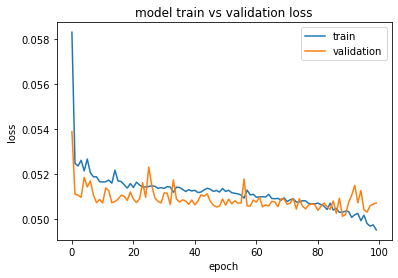

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 100)              22400     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 24,951
Trainable params: 24,951
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
import matplotlib.pyplot as plt

def lstm_model(input_dim, output_dim, feature_size):

    model_lstm = Sequential()
    model_lstm.add(Bidirectional(LSTM(units=50), input_shape=(input_dim, feature_size)))
    model_lstm.add(Dense(25))
    model_lstm.add(Dense(units=output_dim))
    model_lstm.compile(optimizer='adam', loss='mse')
    history = model_lstm.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=1)

    # plot train and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    return model_lstm


model = lstm_model(20, 1, 5)
print(model.summary())


In [40]:
predict = model.predict(x_test)
predict[np.where(predict > 0.8)] = 1
predict[np.where(predict < -0.8)] = -1
predict[(predict[:,:] <= 0.8) | (predict[:,:] >= -0.8)] = 0

34/34 [==============================] - 1s 4ms/step


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(predict, y_test))
print(accuracy_score(predict, y_test))

[[   0    0    0]
 [  31 1007   23]
 [   0    0    0]]
0.9491046182846371


In [56]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

test_data = Ticker_csv.iloc[20 + train_n:,:]

fig = make_subplots(rows=1, cols=1)

fig.add_scatter(y=[8000, 8000, 8000], x=[Ticker_csv[:3].index], mode="markers",
                marker=dict(size=2000000
                            , color="LightSeaGreen"),
                name="a", row=1, col=1)

fig = go.Figure(data=[go.Candlestick(x=test_data.index,
                                     open=test_data['Open'], high=test_data['High'],
                                     low=test_data['Low'], close=test_data['Close'])
                      ])

fig.update_shapes(dict(xref='x', yref='y'))
fig.update_layout(xaxis_rangeslider_visible=False, width=2000, height=1000)
fig.update_layout(
    title='Nasdaq Composite',
    yaxis_title='Stock price',
)




fig.show()
